In [2]:
%load_ext autoreload
%autoreload 2

In [237]:
import numpy as np
import gymnasium as gym
import envpool
import matplotlib.pyplot as plt

In [560]:
from einops import rearrange
import envpool
from tqdm.auto import tqdm

In [505]:
env = gym.make(f"ALE/MontezumaRevenge-v5", frameskip=4, repeat_action_probability=0.0)
obs, info = env.reset()

In [506]:
from threaded_atari_v2 import *

In [507]:
archive = np.load('../goexplore/archive.npy', allow_pickle=True).item()
len(archive)

3283

In [508]:
cells = list(archive.values())

In [509]:
min([len(cell.trajectory) for cell in cells])

1

In [510]:
# cell = [cell for cell in cells if len(cell.trajectory)==1][0]
cell = cells[-500]
len(cell.trajectory), cell.reward

(1471, 3500.0)

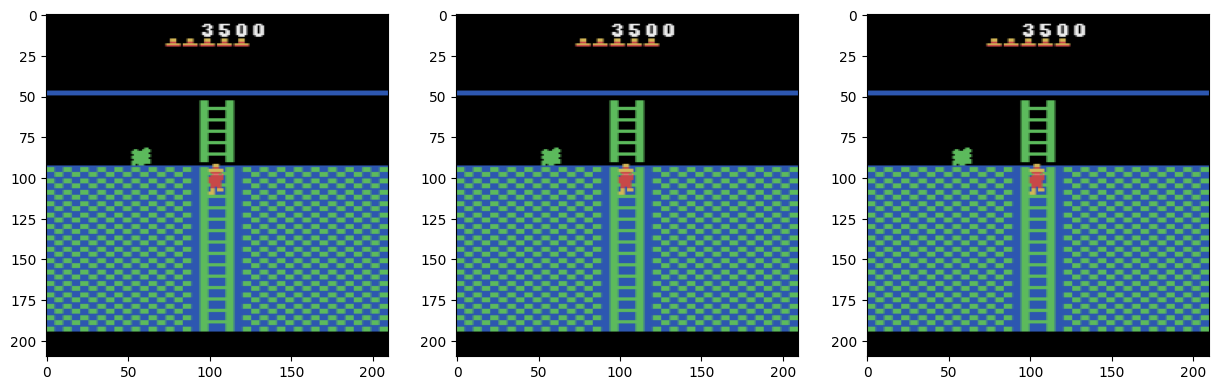

In [511]:
env = gym.make(f"ALE/MontezumaRevenge-v5", frameskip=1, repeat_action_probability=0.0)
env = gym.wrappers.AtariPreprocessing(env, noop_max=1, frame_skip=4, screen_size=210, grayscale_obs=False)
env.reset()

env.restore_state(cell.ram)
obs1, _, _, _, _ = env.step(0)
ram1 = env.ale.getRAM()

env.reset()
for a in cell.trajectory[:]:
    env.step(a)
obs2, _, _, _, _ = env.step(0)
ram2 = env.ale.getRAM()

# assert np.allclose(ram1, ram2)
# assert np.allclose(obs1, obs2)

env = envpool.make_gymnasium('MontezumaRevenge-v5', img_height=210, img_width=210, gray_scale=False, stack_num=1, frame_skip=4, repeat_action_probability=0.0, noop_max=1, use_fire_reset=False)
env.reset()
for a in cell.trajectory[:]:
    env.step(np.array([a]))
obs3, _, _, _, _ = env.step(np.array([0]))
obs3 = rearrange(obs3, '1 c h w -> h w c')

plt.figure(figsize=(15, 5))
plt.subplot(131);plt.imshow(obs1)
plt.subplot(132);plt.imshow(obs2)
plt.subplot(133);plt.imshow(obs3)

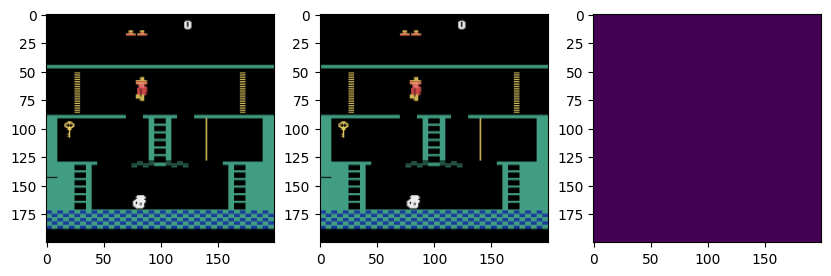

In [455]:
env = gym.make(f"ALE/MontezumaRevenge-v5", frameskip=1, repeat_action_probability=0.0)
env = gym.wrappers.AtariPreprocessing(env, noop_max=1, frame_skip=4, screen_size=200, grayscale_obs=False)
obs1, _ = env.reset()
for i in range(300):
    obs1, _, _, _, _ = env.step(i%18)
# obs1, _, _, _, _ = env.step(0)
# obs1, _, _, _, _ = env.step(1)

env = envpool.make_gymnasium('MontezumaRevenge-v5', img_height=200, img_width=200, gray_scale=False, stack_num=1, frame_skip=4, repeat_action_probability=0.0, noop_max=1, use_fire_reset=False)
obs2, _ = env.reset()
for i in range(300):
    obs2, _, _, _, _ = env.step(np.array([i%18]))
# obs2, _, _, _, _ = env.step(np.array([0]))
# obs2, _, _, _, _ = env.step(np.array([1]))
obs2 = rearrange(obs2, '1 c h w -> h w c')

plt.figure(figsize=(10,3))
plt.subplot(131); plt.imshow(obs1)
plt.subplot(132); plt.imshow(obs2)
plt.subplot(133); plt.imshow((obs1!=obs2).any(axis=-1))

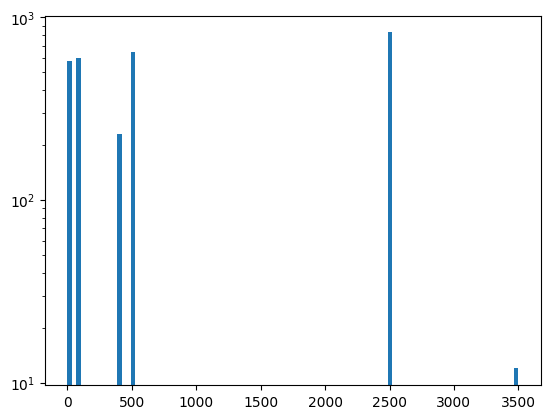

In [469]:
plt.hist([cell.reward for cell in archive.values()], bins=100);
plt.yscale('log')

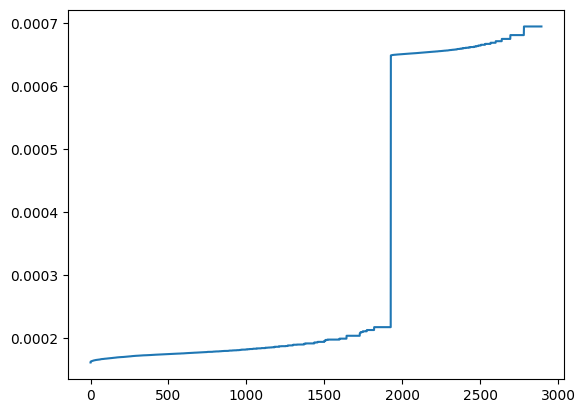

In [470]:
scores = np.array([cell.score for cell in archive.values()])
scores = scores/scores.sum()
plt.plot(scores[scores.argsort()])

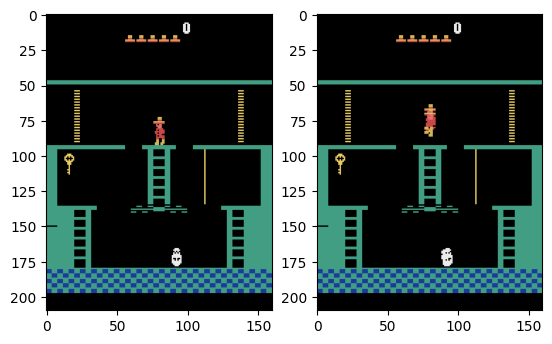

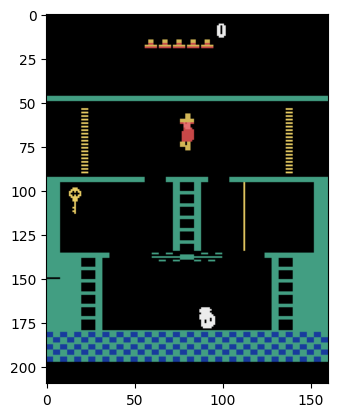

In [185]:
env = envpool.make_gymnasium('MontezumaRevenge-v5', img_height=210, img_width=160, gray_scale=False, stack_num=1, frame_skip=4, repeat_action_probability=0.0, noop_max=1, use_fire_reset=True)
obs2, _ = env.reset()
obs2 = rearrange(obs2, '1 c h w -> h w c')
plt.subplot(121); plt.imshow(obs2)

obs2, _, _, _, _ = env.step(np.array([0]))
obs2 = rearrange(obs2, '1 c h w -> h w c')
plt.subplot(122); plt.imshow(obs2)
plt.show()

obs2, _, _, _, _ = env.step(np.array([0]))
obs2 = rearrange(obs2, '1 c h w -> h w c')
plt.imshow(obs2)
plt.show()


In [13]:
max([len(cell.trajectory) for cell in cells])

180

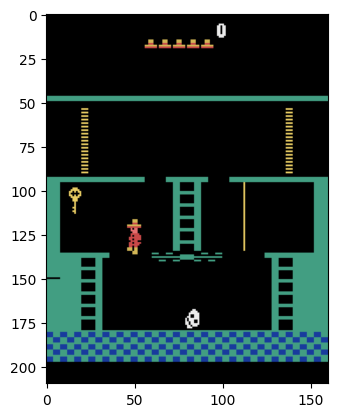

In [14]:
traj = []
env.reset();
for i in range(10):
    a = env.action_space.sample()
    obs, _, _, _, _ = env.step(a)
    traj.append(a)
    state = env.clone_state(True)
    env.reset()
    env.restore_state(state)
state = env.clone_state(True)
obs, _, _, _, _ = env.step(0)
ram = env.ale.getRAM()

plt.imshow(obs)
plt.show()

In [15]:
env.reset()
env.restore_state(state)
obs, _, _, _, _ = env.step(0)
ram1 = env.ale.getRAM()

In [16]:
env.reset()
for a in traj:
    env.step(a)
obs, _, _, _, _ = env.step(0)
ram2 = env.ale.getRAM()

In [17]:
np.allclose(ram, ram1), np.allclose(ram, ram2)

(True, True)

In [36]:
import copy

In [42]:
env = gym.make(f"ALE/{'MontezumaRevenge'}-v5", frameskip=4, repeat_action_probability=0.0)


_, info = env.reset()
max_lives = info["lives"]

archive = defaultdict(lambda: Cell())
highscore = 0
frames = 0
iterations = 0

env = gym.make(f"ALE/{'MontezumaRevenge'}-v5", frameskip=4, repeat_action_probability=0.0)
env.seed(0)
env.action_space.seed(0)
np.random.seed(0)
frame = env.reset()
score = 0
action = 0
trajectory = []
my_iterations = 0

ff = None
for i in range(100):
    found_new_cell = False
    episode_length = 0

    for i in range(100):
        if np.random.random() > 0.95:
            action = env.action_space.sample()

        frame, reward, terminal, trunc, info = env.step(action)
        score += reward
        terminal |= info["lives"] < max_lives
        terminal |= trunc

        trajectory.append(action)
        episode_length += 4

        if score > highscore:
            highscore = score
            best_cell = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        if terminal:
            frames += episode_length
            break
        else:
            cell = cellfn(frame)
            cellhash = hashfn(cell)
            cell = archive[cellhash]
            first_visit = cell.visit()
            if first_visit or score > cell.reward or score == cell.reward and len(trajectory) < len(cell.trajectory):
                
                if cellhash==ff:
                    print('---------', ff)
                    print(first_visit)
                    if not first_visit:
                        print(score > cell.reward)
                        if not score > cell.reward:
                            print(score == cell.reward and len(trajectory) < len(cell.trajectory))
                            print(score, cell.reward, len(trajectory), len(cell.trajectory))
                cell.ram = env.clone_state(True)
                cell.reward = score
                cell.trajectory = copy.deepcopy(trajectory.copy())
                cell.times_chosen = 0
                cell.times_chosen_since_new = 0
                new_cell = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                found_new_cell = True
                if cellhash==ff:
                    print('-')
                    print(first_visit)
                    if not first_visit:
                        print(score > cell.reward)
                        if not score > cell.reward:
                            print(score == cell.reward and len(trajectory) < len(cell.trajectory))
                            print(score, cell.reward, len(trajectory), len(cell.trajectory))
                

    if found_new_cell and my_iterations > 0:
        restore_cell.times_chosen_since_new = 0

    scores = np.array([cell.score for cell in archive.values()])
    hashes = [cellhash for cellhash in archive.keys()]
    probs = scores / scores.sum()
    restore = np.random.choice(hashes, p=probs)
    restore_cell = archive[restore]
    ram, score, trajectory = restore_cell.choose()
    if restore==ff:
        print('restoring root ', len(trajectory))
    env.reset()
    env.restore_state(ram)
    my_iterations += 1
    iterations += 1


--------- -5718259304823463892
True
-
True
restoring root  1
restoring root  1
restoring root  1


In [516]:
traj_lens = np.array([len(cell.trajectory) for cell in archive.values()])
traj_rets = np.array([cell.reward for cell in archive.values()])




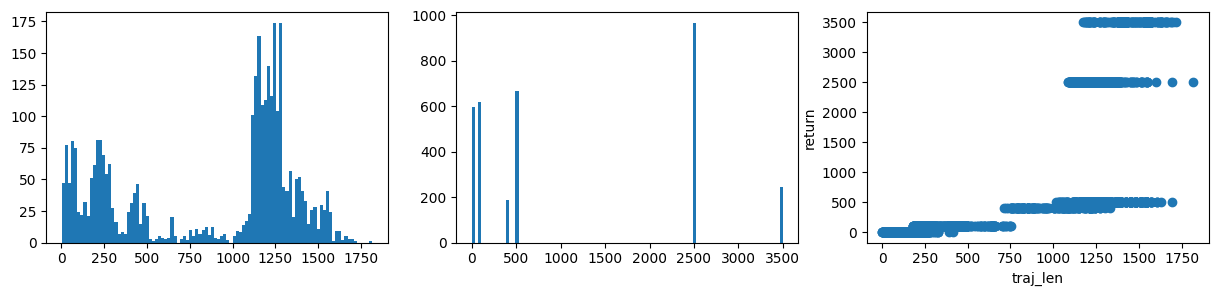

In [525]:
plt.figure(figsize=(15,3))
plt.subplot(131); plt.hist(traj_lens, bins=100);
plt.subplot(132); plt.hist(traj_rets, bins=100);
plt.subplot(133); plt.scatter(traj_lens, traj_rets); plt.xlabel('traj_len'); plt.ylabel('return');

In [561]:
cell = np.random.choice(list(archive.values()))

In [562]:
for _ in tqdm(range(1000)):
    env = envpool.make_gymnasium('MontezumaRevenge-v5', img_height=210, img_width=210, gray_scale=False, stack_num=1, frame_skip=4, repeat_action_probability=0.0, noop_max=1, use_fire_reset=False)
    env.reset()
    for a in cell.trajectory[:]:
        obs, _, _, _, _ = env.step(np.array([a]))
        obs = rearrange(obs, '1 c h w -> h w c')

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

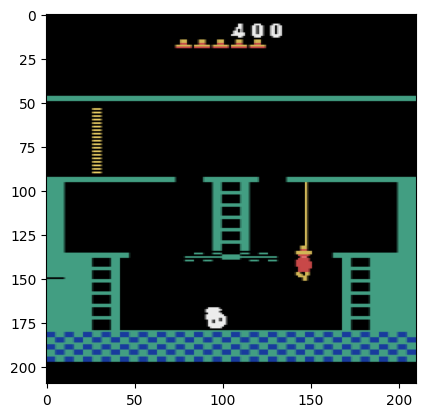

In [556]:
plt.imshow(obs)

In [568]:
env = envpool.make_gymnasium('MontezumaRevenge-v5', num_envs=10, img_height=210, img_width=210, gray_scale=False, stack_num=1, frame_skip=4, repeat_action_probability=0.0, noop_max=1, use_fire_reset=False)

ModuleNotFoundError: No module named 'buffers'

In [567]:
obs.shape

(3, 3, 210, 210)

In [460]:
cells = list(archive.values())

In [475]:
for cell in cells[-20:]:
    print(cell.trajectory[:30])

[0, 0, 0, 0, 0, 0, 0, 0, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 8, 14, 14, 14, 14, 14, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 8, 14, 14, 14, 14, 14, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 8, 14, 14, 14, 14, 14, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 8, 14, 14, 14, 14, 14, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 8, 14, 14, 14, 14, 14, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 8, 14, 14, 14, 14, 14, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 8, 14, 14, 14, 14, 14, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 8, 14, 14, 14, 14, 14, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 8, 14, 14, 14, 14, 14, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 14, 14, 14, 

In [457]:
env = envpool.make_gymnasium('Breakout-v5', img_height=210, img_width=210, gray_scale=False, stack_num=1, frame_skip=4, repeat_action_probability=0.0, noop_max=1, use_fire_reset=False)
env.reset();